# Implementing LASSO Regression with Coordinate Descent and the Subgradient of the L1 Penalty with Soft Thresholding

This problem appeared as an assignment in the *coursera course Machine Learning – Regression*, part of *Machine Learning specialization* by the University of Washington. The following description of the problem is taken directly from the assignment.

The goal of this assignment is to implement an *LASSO Solver* using *coordinate descent*. The following are the sub-tasks:

* First the features are needed to be *normalized*. 
* The *coordinate descent* for *LASSO* needs to be implemented (with the *subgradient* of the *L1 penalty*).
* The effects of *L1 penalty* are going to be explored.

The following dataset is from house sales in *King County*, the region where the city of Seattle, WA is located. This is going to be our input datatset for training the LASSO model, with the *response variable* as **price**.

In [1]:
#sales = graphlab.SFrame('C:/courses/Coursera/Past/Specialization-UW Machine Learning/ML Regression/Week5/kc_house_data.gl/')
import pandas as pd
sales = pd.read_csv('C:/courses/Coursera/Past/Specialization-UW Machine Learning/ML Regression/Week5/kc_house_data.csv')
# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to int, before using it below
sales['floors'] = sales['floors'].astype(int) 
#print sales.dtypes
sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [2]:
import numpy as np # note this allows us to refer to numpy as np instead 

In [3]:
def get_numpy_data(data_frame, features, output):
    data_frame['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_frame = data_frame[features]
    print type(features_frame)
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_frame.as_matrix() #.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_array = data_frame[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_array.as_matrix() #.to_numpy()
    return(feature_matrix, output_array)

In [4]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

# Normalize features
In the house dataset, features vary wildly in their relative magnitude: `sqft_living` is very large overall compared to `bedrooms`, for instance. As a result, weight for `sqft_living` would be much smaller than weight for `bedrooms`. This is problematic because "small" weights are dropped first as `l1_penalty` goes up. 

To give equal considerations for all features, we need to **normalize features** by dividing each feature by its *2-norm* so that the transformed feature has norm 1.

Let's see how we can do this normalization easily with Numpy: let us first consider a small matrix.

In [5]:
X = np.array([[3.,5.,8.],[4.,12.,15.]])
print X

[[  3.   5.   8.]
 [  4.  12.  15.]]


Numpy provides a shorthand for computing 2-norms of each column:

In [6]:
norms = np.linalg.norm(X, axis=0) # gives [norm(X[:,0]), norm(X[:,1]), norm(X[:,2])]
print norms

[  5.  13.  17.]


To normalize, apply element-wise division:

In [7]:
print X / norms # gives [X[:,0]/norm(X[:,0]), X[:,1]/norm(X[:,1]), X[:,2]/norm(X[:,2])]

[[ 0.6         0.38461538  0.47058824]
 [ 0.8         0.92307692  0.88235294]]


Using the shorthand we just covered, write a short function called `normalize_features(feature_matrix)`, which normalizes columns of a given feature matrix. The function should return a pair `(normalized_features, norms)`, where the second item contains the norms of original features. As discussed in the lectures, we will use these norms to normalize the test data in the same way as we normalized the training data. 

In [8]:
def normalize_features(feature_matrix):
    norm = np.linalg.norm(feature_matrix, axis=0)
    return (feature_matrix / norm, norm)

To test the function, run the following:

In [9]:
features, norms = normalize_features(np.array([[3.,6.,9.],[4.,8.,12.]]))
print features
# should print
# [[ 0.6  0.6  0.6]
#  [ 0.8  0.8  0.8]]
print norms
# should print
# [5.  10.  15.]

[[ 0.6  0.6  0.6]
 [ 0.8  0.8  0.8]]
[  5.  10.  15.]


# Implementing Coordinate Descent with normalized features

The following theory is going to be used to implement the coordinate descent:

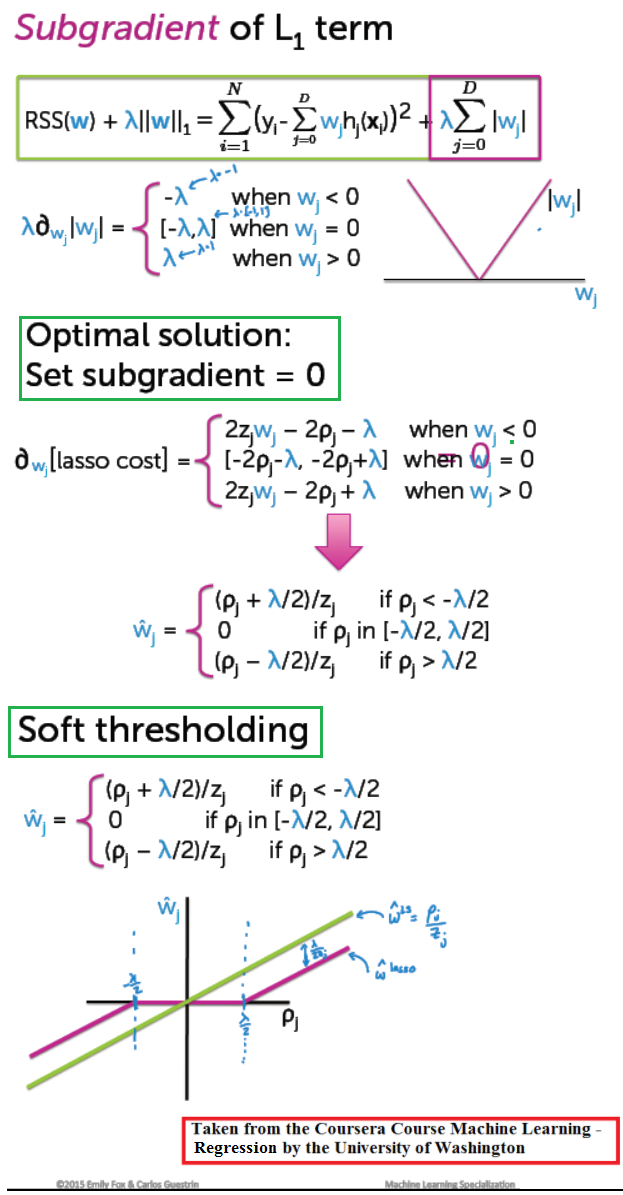

In [26]:
from IPython.display import Image
Image(filename='C:/courses/Coursera/Past/Specialization-UW Machine Learning/ML Regression/Week5/im2.png')

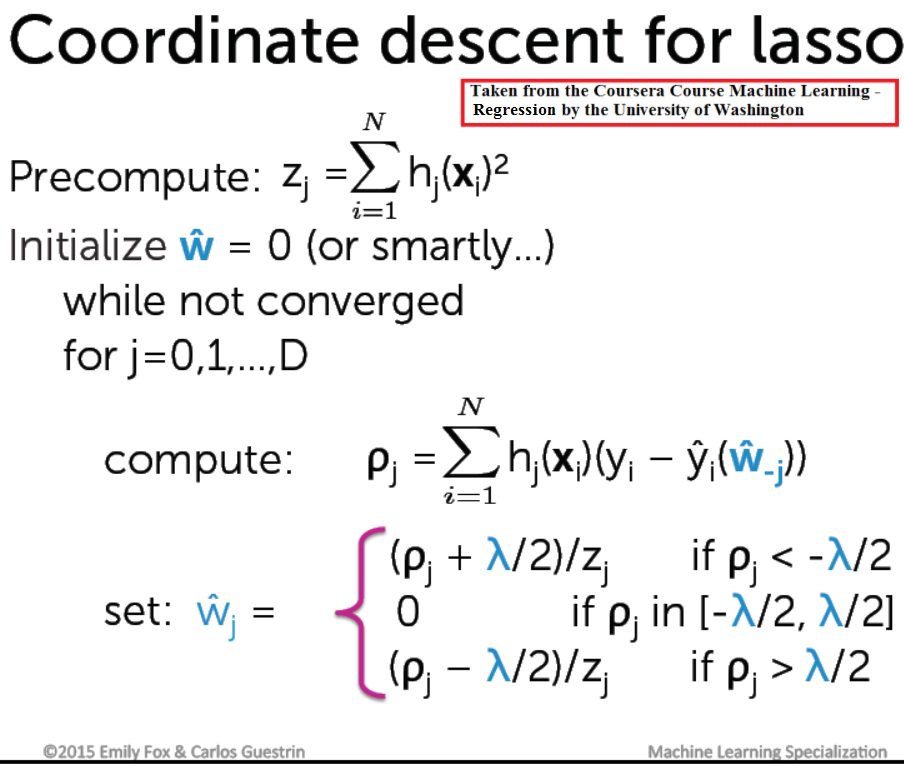

In [11]:
Image(filename='C:/courses/Coursera/Past/Specialization-UW Machine Learning/ML Regression/Week5/im1.png', width=700, height=500)

We seek to obtain a sparse set of weights by minimizing the *LASSO cost function* $$\sum\limits_{j=1}^{N}{ (prediction_j - output_j)^2 } + \sum\limits_{i=1}^{k}{\lambda|w_i|}$$ where we have *N* data points in the training dataset and *k* features, where $prediction_j=\hat{w}.\hat{feature_j}$ for the $j^{th}$ datapoint.

(By convention, we do not include $w_0$ in the *L1 penalty term*. We never want to push the intercept to zero.)

The absolute value sign makes the cost function *non-differentiable*, so simple *gradient descent* is not viable (we need to implement a method called **subgradient descent**). Instead, we will use **coordinate descent**: at each iteration, we will fix all weights but weight `i` and find the value of weight `i` that minimizes the objective. That is, we look for
$$argmin_{w_{i}}\sum\limits_{j=1}^{N}{ (prediction_j - output_j)^2 } + \sum\limits_{i=1}^{k}{\lambda|w_i|}$$,
where all weights other than $w_i$ are held to be constant. We will optimize one $w_i$ at a time, circling through the weights multiple times.

  1. Pick a coordinate `i`.
  2. Compute `w_i` that minimizes the cost function $\sum\limits_{j=1}^{N}{ (prediction_j - output_j)^2 } + \sum\limits_{i=1}^{k}{\lambda|w_i|}$.
  3. Repeat Steps *1* and *2* for *all coordinates*, multiple times.

For this notebook, we use **cyclical coordinate descent with normalized features**, where we cycle through coordinates 0 to (k-1) in order, and assume the features were normalized as discussed above. The formula for optimizing each coordinate is as follows:

$$w_i=
    \left\{
    \begin{array}{lr}
      \rho_i+\frac{\lambda}{2},& \rho_i < -\frac{\lambda}{2} \\
      0,&  -\frac{\lambda}{2} \leq \rho_i \leq \frac{\lambda}{2} \\
      \rho_i-\frac{\lambda}{2},& \rho_i > \frac{\lambda}{2} 
    \end{array}
    \right\}
$$

where

$$\rho_i = \sum \limits_j { feature_i(output_j - prediction_j + w_i.feature_i)}$$.

Note that we do not regularize the weight of the constant feature (intercept) $w_0$, so, for this weight, the update is simply:
$w_0 = \rho_i$.


## Effect of L1 penalty

Let us consider a simple model with 2 features:

In [12]:
simple_features = ['sqft_living', 'bedrooms']
my_output = 'price'
(simple_feature_matrix, output) = get_numpy_data(sales, simple_features, my_output)

<class 'pandas.core.frame.DataFrame'>


Don't forget to normalize features:

In [13]:
simple_feature_matrix, norms = normalize_features(simple_feature_matrix)

We assign some random set of initial weights and inspect the values of `ro[i]`:

In [14]:
weights = np.array([1., 4., 1.])

Use `predict_output()` to make predictions on this data.

In [15]:
prediction = predict_output(simple_feature_matrix, weights)
print prediction

[ 0.02675867  0.04339256  0.01990703 ...,  0.02289873  0.03178473
  0.02289873]


Compute the values of `ro[i]` for each feature in this simple model, using the formula given above, using the formula:
```
ro[i] = SUM[ [feature_i]*(output - prediction + w[i]*[feature_i]) ]
```

*Hint: You can get a Numpy vector for feature_i using:*
```
simple_feature_matrix[:,i]
```

In [16]:
#print simple_feature_matrix.shape[1]
ro = [sum(simple_feature_matrix[:,i]*(output - prediction + weights[i] * simple_feature_matrix[:,i])) for i in range(simple_feature_matrix.shape[1])]
ro

[79400300.014523208, 87939470.823251516, 80966698.666239053]

***QUIZ QUESTION***

Recall that, whenever `ro[i]` falls between `-l1_penalty/2` and `l1_penalty/2`, the corresponding weight `w[i]` is sent to zero. Now suppose we were to take one step of coordinate descent on either feature 1 or feature 2. What range of values of `l1_penalty` **would not** set `w[1]` zero, but **would** set `w[2]` to zero, if we were to take a step in that coordinate? 

In [17]:
# -l1_penalty/2 <= ro[i] <= l1_penalty/2
l1_penalty = 2*80966698.67596525
print ro[1] <= l1_penalty/2
print ro[2] <= l1_penalty/2
l1_penalty = 2*87939470.772990793 - 1
print ro[1] <= l1_penalty/2
print ro[2] <= l1_penalty/2
print 2*80966698.67596525, 2*87939470.772990793 - 1 # in this range, inclusive

False
True
False
True
161933397.352 175878940.546


***QUIZ QUESTION***

What range of values of `l1_penalty` would set **both** `w[1]` and `w[2]` to zero, if we were to take a step in that coordinate? 

In [18]:
l1_penalty = 2*87939470.772990793 - 1
print ro[1] <= l1_penalty/2
print ro[2] <= l1_penalty/2
l1_penalty = 2*87939470.772990793 
print ro[1] <= l1_penalty/2
print ro[2] <= l1_penalty/2
print 2*87939470.772990793 # greater than this value

False
True
False
True
175878941.546


So we can say that `ro[i]` quantifies the significance of the i-th feature: the larger `ro[i]` is, the more likely it is for the i-th feature to be retained.

## Single Coordinate Descent Step

Using the formula above, let's implement *coordinate descent* that *minimizes* the *cost function* over a *single feature i*. Note that the intercept (weight 0) is not regularized. The function should accept feature matrix, output, current weights, l1 penalty, and index of feature to optimize over. The function should return new weight for feature i.

In [19]:
def lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty):
    
    # compute prediction
    prediction = predict_output(feature_matrix, weights)
    # compute ro[i] = SUM[ [feature_i]*(output - prediction + weight[i]*[feature_i]) ]
    ro_i = sum(feature_matrix[:,i] * (output - prediction + weights[i] * feature_matrix[:,i]))

    if i == 0: # intercept -- do not regularize
        new_weight_i = ro_i 
    elif ro_i < -l1_penalty/2:
        new_weight_i = (ro_i + l1_penalty/2)
    elif ro_i > l1_penalty/2:
        new_weight_i = (ro_i - l1_penalty/2)
    else:
        new_weight_i = 0
    
    return new_weight_i

To test the function, run the following cell:

In [20]:
# should print 0.425558846691
import math
print lasso_coordinate_descent_step(1, np.array([[3./math.sqrt(13),1./math.sqrt(10)],[2./math.sqrt(13),3./math.sqrt(10)]]), 
                                   np.array([1., 1.]), np.array([1., 4.]), 0.1)

0.425558846691


## Cyclical coordinate descent 

Now that we have a function that optimizes the cost function over a single coordinate, let us implement cyclical coordinate descent where we optimize coordinates 0, 1, ..., (k-1) in order and repeat.

When do we know to stop? Each time we scan all the coordinates (features) once, we measure the change in weight for each coordinate. If no coordinate changes by more than a specified threshold, we stop.

For each iteration:
1. As we loop over features in order and perform coordinate descent, measure how much each coordinate changes.
2. After the loop, if the maximum change across all coordinates is falls below the tolerance, stop. Otherwise, go back to step 1.

Return weights

**IMPORTANT: when computing a new weight for coordinate i, make sure to incorporate the new weights for coordinates 0, 1, ..., i-1. One good way is to update your weights variable in-place. See following pseudocode for illustration.**
```
for i in range(len(weights)):
    old_weights_i = weights[i] # remember old value of weight[i], as it will be overwritten
    # the following line uses new values for weight[0], weight[1], ..., weight[i-1]
    #     and old values for weight[i], ..., weight[d-1]
    weights[i] = lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty)
    
    # use old_weights_i to compute change in coordinate
    ...
```

In [21]:
def lasso_cyclical_coordinate_descent(feature_matrix, output, initial_weights, l1_penalty, tolerance):
    
    weights, converged = np.array(initial_weights), False
    while not converged:
        changes = np.zeros(len(weights))
        for i in range(len(weights)):
            old_weights_i = weights[i] # remember old value of weight[i], as it will be overwritten
            # the following line uses new values for weight[0], weight[1], ..., weight[i-1]
            #     and old values for weight[i], ..., weight[d-1]
            weights[i] = lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty)
            # use old_weights_i to compute change in coordinate
            changes[i] = abs(old_weights_i - weights[i])
        #print weights, changes, max(changes)
        if max(changes) < tolerance:
            converged = True
    return weights    

Using the following parameters, learn the weights on the sales dataset. 

In [22]:
simple_features = ['sqft_living', 'bedrooms']
my_output = 'price'
initial_weights = np.zeros(3)
l1_penalty = 1e7
tolerance = 1.0

First create a normalized version of the feature matrix, `normalized_simple_feature_matrix`

In [23]:
(simple_feature_matrix, output) = get_numpy_data(sales, simple_features, my_output)
(normalized_simple_feature_matrix, simple_norms) = normalize_features(simple_feature_matrix) # normalize features

<class 'pandas.core.frame.DataFrame'>


Then, run your implementation of LASSO coordinate descent:

In [24]:
weights = lasso_cyclical_coordinate_descent(normalized_simple_feature_matrix, output,
                                            initial_weights, l1_penalty, tolerance)
prediction = predict_output(normalized_simple_feature_matrix, weights)
RSS = sum((output - prediction)**2)  
print RSS
print weights

1.63049247672e+15
[ 21624997.95951872  63157247.20788978         0.        ]


In [25]:
lambdas = [10**k for k in range(1,10)]
df = pd.DataFrame()
for l1_penalty in lambdas:
    weights = lasso_cyclical_coordinate_descent(normalized_simple_feature_matrix, output, initial_weights, l1_penalty, tolerance)    
    df=df.append(pd.DataFrame([np.hstack((l1_penalty, weights))], columns=['lambda']+['w' + str(i) for i in range(len(weights))]), ignore_index=True)
    #df=df.append(pd.DataFrame([weights], index=[l1_penalty], columns=['w' + str(i) for i in range(len(weights))]), ignore_index=True)
print df
df.to_csv('C:/courses/Coursera/Past/Specialization-UW Machine Learning/ML Regression/Week5/weights1.csv')

       lambda               w0            w1               w2
0          10  11683017.690976  1.049396e+08 -29336507.819234
1         100  11682459.123622  1.049388e+08 -29335192.854556
2        1000  11676873.450086  1.049310e+08 -29322043.207756
3       10000  11621016.714715  1.048535e+08 -29190546.739771
4      100000  11062449.361008  1.040784e+08 -27875582.059913
5     1000000   5476775.823946  9.632761e+07 -14725935.261329
6    10000000  21624997.959519  6.315725e+07         0.000000
7   100000000  79400304.637645  0.000000e+00         0.000000
8  1000000000  79400304.637645  0.000000e+00         0.000000


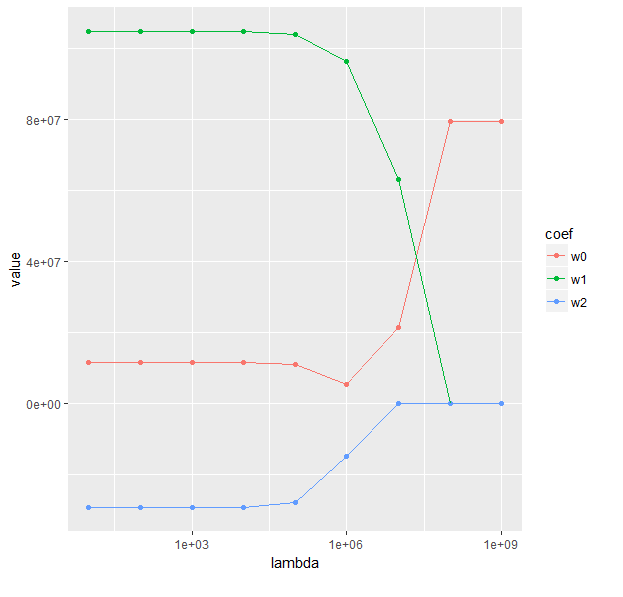

In [27]:
Image(filename='C:/courses/Coursera/Past/Specialization-UW Machine Learning/ML Regression/Week5/im3.png')

***QUIZ QUESTIONS***
1. What is the RSS of the learned model on the normalized dataset?
2. Which features had weight zero at convergence?

# Evaluating LASSO fit with more features

Let us split the sales dataset into training and test sets.

In [28]:
train_data = sales.sample(frac=0.8,random_state=0) #sales.random_split(.8,seed=0)
test_data = sales.drop(train_data.index)

Let us consider the following set of features.

In [29]:
all_features = ['bedrooms',
                'bathrooms',
                'sqft_living',
                'sqft_lot',
                'floors',
                'waterfront', 
                'view', 
                'condition', 
                'grade',
                'sqft_above',
                'sqft_basement',
                'yr_built', 
                'yr_renovated']

First, create a normalized feature matrix from the TRAINING data with these features.  (Make you store the norms for the normalization, since we'll use them later)

In [30]:
(feature_matrix, output) = get_numpy_data(train_data, all_features, my_output)
(normalized_feature_matrix, norms) = normalize_features(feature_matrix) # normalize features

<class 'pandas.core.frame.DataFrame'>


C:\Users\Sandipan.Dey\Anaconda\envs\dato-env\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


First, learn the weights with `l1_penalty=1e7`, on the training data. Initialize weights to all zeros, and set the `tolerance=1`.  Call resulting weights `weights1e7`, you will need them later.

In [31]:
initial_weights = np.zeros(len(all_features)+1)
weights1e7 = lasso_cyclical_coordinate_descent(normalized_feature_matrix, output,
                                            initial_weights, l1_penalty, tolerance)
print weights1e7

[ 71103860.56865762         0.                 0.                 0.
         0.                 0.                 0.                 0.
         0.                 0.                 0.                 0.
         0.                 0.        ]


***QUIZ QUESTION***

What features had non-zero weight in this case?

Next, learn the weights with `l1_penalty=1e8`, on the training data. Initialize weights to all zeros, and set the `tolerance=1`.  Call resulting weights `weights1e8`, you will need them later.

In [32]:
l1_penalty=1e8
weights1e8 = lasso_cyclical_coordinate_descent(normalized_feature_matrix, output,
                                            initial_weights, l1_penalty, tolerance)
print weights1e8

[ 71103860.56865762         0.                 0.                 0.
         0.                 0.                 0.                 0.
         0.                 0.                 0.                 0.
         0.                 0.        ]


In [39]:
lambdas = [10**k for k in range(6,12)]
df = pd.DataFrame()
RSSs = []
for l1_penalty in lambdas:
    print l1_penalty
    weights = lasso_cyclical_coordinate_descent(normalized_feature_matrix, output, initial_weights, l1_penalty, tolerance)    
    df=df.append(pd.DataFrame([np.hstack((l1_penalty, weights))], columns=['lambda']+['w' + str(i) for i in range(len(weights))]), ignore_index=True)
    prediction = predict_output(normalized_feature_matrix, weights)
    RSSs.append(sum((output - prediction)**2))  
    #df=df.append(pd.DataFrame([weights], index=[l1_penalty], columns=['w' + str(i) for i in range(len(weights))]), ignore_index=True)
print df
print RSSs
df.to_csv('C:/courses/Coursera/Past/Specialization-UW Machine Learning/ML Regression/Week5/weights2.csv')

1000000
10000000
100000000
1000000000
10000000000
100000000000
         lambda               w0              w1  w2               w3  \
0  1.000000e+06 -53495148.024173 -3900349.715589   0  57556647.815723   
1  1.000000e+07  24404839.697925        0.000000   0  48405408.127194   
2  1.000000e+08  71103860.568658        0.000000   0         0.000000   
3  1.000000e+09  71103860.568658        0.000000   0         0.000000   
4  1.000000e+10  71103860.568658        0.000000   0         0.000000   
5  1.000000e+11  71103860.568658        0.000000   0         0.000000   

              w4  w5              w6              w7              w8  \
0 -940584.994978   0  5876278.629265  6863064.028083  8074720.147385   
1       0.000000   0  2602711.362252  7501070.759108        0.000000   
2       0.000000   0        0.000000        0.000000        0.000000   
3       0.000000   0        0.000000        0.000000        0.000000   
4       0.000000   0        0.000000        0.000000        0.000

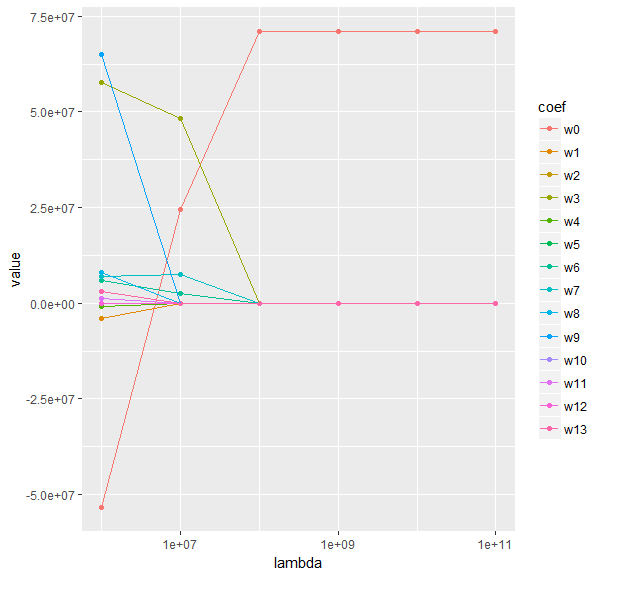

In [40]:
Image(filename='C:/courses/Coursera/Past/Specialization-UW Machine Learning/ML Regression/Week5/im4.png')

***QUIZ QUESTION***

What features had non-zero weight in this case?

Finally, learn the weights with `l1_penalty=1e4`, on the training data. Initialize weights to all zeros, and set the `tolerance=5e5`.  Call resulting weights `weights1e4`, you will need them later.  (This case will take quite a bit longer to converge than the others above.)

In [84]:
l1_penalty=1e4
tolerance=5e5
weights1e4 = lasso_cyclical_coordinate_descent(normalized_feature_matrix, output,
                                            initial_weights, l1_penalty, tolerance)
print weights1e4

[ 77779073.91265011 -22884012.25023269  15348487.08089937
  92166869.69883157  -2139328.08242773  -8818455.54409456
   6494209.73310656   7065162.05053201   4119079.21006776
  18436483.52618789 -14566678.54514417  -5528348.75179453
 -83591746.20730399   2784276.46012857]


***QUIZ QUESTION***

What features had non-zero weight in this case?

## Rescaling learned weights

Recall that we normalized our feature matrix, before learning the weights.  To use these weights on a test set, we must normalize the test data in the same way.

Alternatively, we can rescale the learned weights to include the normalization, so we never have to worry about normalizing the test data: 

In this case, we must scale the resulting weights so that we can make predictions with *original* features:
 1. Store the norms of the original features to a vector called `norms`:
```
features, norms = normalize_features(features)
```
 2. Run Lasso on the normalized features and obtain a `weights` vector
 3. Compute the weights for the original features by performing element-wise division, i.e.
```
weights_normalized = weights / norms
```
Now, we can apply `weights_normalized` to the test data, without normalizing it!

Create a normalized version of each of the weights learned above. (`weights1e4`, `weights1e7`, `weights1e8`).

In [87]:
(normalized_feature_matrix, norms) = normalize_features(feature_matrix) # normalize features
l1_penalty=1e7
tolerance=1
weights_normalized = weights1e7 / norms
print weights_normalized

[  1.85285533e+05   0.00000000e+00   0.00000000e+00   1.61317456e+02
   0.00000000e+00   0.00000000e+00   2.87664700e+05   6.91937057e+04
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


To check your results, if you call `normalized_weights1e7` the normalized version of `weights1e7`, then:
```
print normalized_weights1e7[3]
```
should return 161.31745624837794.

## Evaluating each of the learned models on the test data

Let's now evaluate the three models on the test data:

In [89]:
(test_feature_matrix, test_output) = get_numpy_data(test_data, all_features, 'price')

<class 'graphlab.data_structures.sframe.SFrame'>


Compute the RSS of each of the three normalized weights on the (unnormalized) `test_feature_matrix`:

In [90]:
weights_normalized = weights1e7 / norms
prediction = predict_output(test_feature_matrix, weights_normalized)
RSS = sum((test_output - prediction)**2)  
print RSS

2.75962079909e+14


In [91]:
weights_normalized = weights1e8 / norms
prediction = predict_output(test_feature_matrix, weights_normalized)
RSS = sum((test_output - prediction)**2)  
print RSS

5.37166150034e+14


In [92]:
weights_normalized = weights1e4 / norms
prediction = predict_output(test_feature_matrix, weights_normalized)
RSS = sum((test_output - prediction)**2)  
print RSS

2.2778100476e+14


***QUIZ QUESTION***

Which model performed best on the test data?